In [83]:
%matplotlib inline

Comparison of training a hardware efficient ansatz with a global cost function and the gadget equivalent

Necessary imports

In [84]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
# import datetime

from gadget_utils import hardware_efficient_ansatz, cat_state_preparation

np.random.seed(42)

Defining the relevant parameters of the simulation

In [85]:
computational_qubits = 4
ancillary_qubits = 4
perturbation_factor = 0
num_layers = 1
# locality = 2
max_iter = 100
num_samples = 200

Global cost function
--------

file to save the results

In [86]:
# with open('../../results/data/{}_training_global_{}qubits_{}layers_{}lambda_{}samples.dat'
#             .format(datetime.datetime.now().strftime("%y%m%d"),
#                     num_qubits, num_layers, perturbation_factor, num_samples), 'w') as of:
#     of.write('# iteration\tcost')

creating the quantum device with the right number of qubits

In [87]:
dev_comp = qml.device("default.qubit", wires=range(computational_qubits))

creating the qunode using the imported methods

In [88]:
def computational_circuit(angles, measured_qubits):
    assert(len(np.shape(angles)) == 2)                  # check proper dimensions of params
    total_qubits = np.shape(angles)[1]
    if total_qubits > measured_qubits:
        # /!\ keep the 'ancillary_qubits = ' (has to be a keyword argument)
        cat_state_preparation(ancillary_qubits = range(measured_qubits, total_qubits, 1))
    hardware_efficient_ansatz(angles)
    H = qml.PauliZ(0)
    for qubit in range(measured_qubits-1):
        H = H @ qml.PauliZ(qubit + 1)
    return qml.expval(H)

computational_qnode = qml.QNode(computational_circuit, dev_comp)

(defining the cost function)

In [89]:
def computational_cost_function(angles, computational_qubits):
    return computational_qnode(angles, computational_qubits)

Choosing an optimizer

In [90]:
opt = qml.GradientDescentOptimizer(stepsize=0.4)

Initializing the parameters

In [91]:
weights_init = np.random.uniform(0, np.pi, size=(num_layers, computational_qubits), requires_grad=True)
cost_computational = [computational_cost_function(weights_init, computational_qubits)]

Optimization loop

In [92]:
weights = weights_init
for it in range(max_iter):
    # /!\ keyword arguments are not trained? don't know why but don't remove the 'computational_qubits='
    # keyword arguments are not wrapped https://discuss.pennylane.ai/t/wire-error-on-ibm-simulator/1282
    weights = opt.step(computational_cost_function, weights, computational_qubits=computational_qubits)
    cost_computational.append(computational_cost_function(weights, computational_qubits))
    # opt.update_stepsize(stepsize)
    if it % 2 == 0:
        print("Iteration = {:5d} | Cost function = {: .8f}".format(it+1, cost_computational[-1]))


Iteration =     1 | Cost function =  0.23683875
Iteration =     3 | Cost function = -0.26698478
Iteration =     5 | Cost function =  0.25845163
Iteration =     7 | Cost function =  0.24949856
Iteration =     9 | Cost function = -0.01481921
Iteration =    11 | Cost function =  0.02585627
Iteration =    13 | Cost function =  0.18653176
Iteration =    15 | Cost function =  0.18524942
Iteration =    17 | Cost function = -0.16327900
Iteration =    19 | Cost function =  0.02892816
Iteration =    21 | Cost function =  0.18784066
Iteration =    23 | Cost function = -0.00237907
Iteration =    25 | Cost function =  0.03706822
Iteration =    27 | Cost function =  0.21683755
Iteration =    29 | Cost function = -0.03921593
Iteration =    31 | Cost function =  0.01064553
Iteration =    33 | Cost function =  0.03145086
Iteration =    35 | Cost function = -0.05096345
Iteration =    37 | Cost function =  0.01176974
Iteration =    39 | Cost function = -0.20298978
Iteration =    41 | Cost function = -0.1

Saving and plotting the results

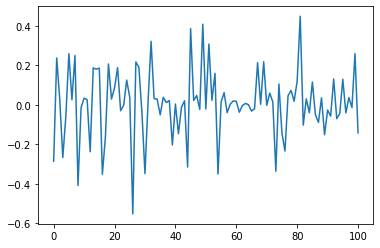

In [94]:
plt.plot(np.arange(max_iter+1), cost_computational)
plt.show()

Gadget cost function
--------

file to save the results

In [95]:
# with open('../../results/data/{}_training_gadget_{}qubits_{}layers_{}lambda_{}samples.dat'
#             .format(datetime.datetime.now().strftime("%y%m%d"),
#                     num_qubits, num_layers, perturbation_factor, num_samples), 'w') as of:
#     of.write('# iteration\tcost computational\tcost gadget')

creating the quantum device with the right number of qubits

In [96]:
dev_gad = qml.device("default.qubit", wires=range(computational_qubits+ancillary_qubits))

creating the qunode using the imported methods

In [97]:
def gadget_circuit(params, computational_qubits):       # also working for k'-local 
    assert(len(np.shape(params)) == 2)                  # check proper dimensions of params
    total_qubits = np.shape(params)[1]
    cat_state_preparation(ancillary_qubits = range(computational_qubits, total_qubits, 1))
    hardware_efficient_ansatz(params)

Defining the cost function

In [98]:
@qml.qnode(dev_gad)
def unperturbed_qnode(params, computational_qubits, target_qubits):
    gadget_circuit(params, computational_qubits)
    term = qml.Identity(target_qubits[0]) @ qml.Identity(target_qubits[1]) - qml.PauliZ(target_qubits[0]) @ qml.PauliZ(target_qubits[1])
    return qml.expval(term)


@qml.qnode(dev_gad)
def perturbation_qnode(params, computational_qubits, target_qubits):
    gadget_circuit(params, computational_qubits)
    term = qml.PauliZ(target_qubits[0]) @ qml.PauliX(computational_qubits+target_qubits[0])
    return qml.expval(term)


def gadget_cost_function(params, computational_qubits):
    assert(len(np.shape(params)) == 2)                  # check proper dimensions of params
    total_qubits = np.shape(params)[1]
    expectation_value = 0
    # creating the "unperturbed Hamiltonian"
    # acting on the ancillary qubits only
    for first_qubit in range(computational_qubits, total_qubits):
        for second_qubit in range(first_qubit+1, total_qubits):
            expectation_value += unperturbed_qnode(params, computational_qubits, [first_qubit, second_qubit])
    # creating the perturbation part of the Hamiltonian
    # acting on both ancillary and target qubits with the same index
    for qubit in range(computational_qubits):           # /!\ only valid for 2-local
        expectation_value += perturbation_qnode(params, computational_qubits, [qubit])
    return expectation_value

Creating the control cost function

In [99]:
control_qnode = qml.QNode(computational_circuit, dev_gad)
def control_cost_function(params, computational_qubits):
    return control_qnode(params, computational_qubits)

Choosing an optimizer

In [100]:
opt = qml.GradientDescentOptimizer(stepsize=0.4)

Initializing the parameters

In [101]:
weights_init = np.random.uniform(0, np.pi, size=(num_layers, computational_qubits+ancillary_qubits), requires_grad=True)
cost_computational = [control_cost_function(weights_init, computational_qubits=computational_qubits)]
cost_gadget = [gadget_cost_function(weights_init, computational_qubits)]


Optimization loop

In [102]:
weights = weights_init
for it in range(max_iter):
    weights, prev_cost = opt.step_and_cost(gadget_cost_function, weights, computational_qubits=computational_qubits)
    cost_computational.append(control_cost_function(weights, computational_qubits))
    cost_gadget.append(gadget_cost_function(weights, computational_qubits))
    # opt.update_stepsize(stepsize)
    if it % 2 == 0:
        print(f"Iteration = {it:5d} | " +
               "Gadget cost = {:.8f} | ".format(cost_gadget[-1]) +
               "Computational cost = {:.8f}".format(cost_computational[-1]))


Iteration =     0 | Gadget cost = 6.06719729 | Computational cost = -0.48517634
Iteration =     2 | Gadget cost = 4.33710476 | Computational cost = 0.09426185
Iteration =     4 | Gadget cost = 5.06078279 | Computational cost = -0.26589414
Iteration =     6 | Gadget cost = 5.92215744 | Computational cost = 0.22109592
Iteration =     8 | Gadget cost = 5.41562630 | Computational cost = 0.32836130
Iteration =    10 | Gadget cost = 4.89969931 | Computational cost = -0.05022014
Iteration =    12 | Gadget cost = 6.46884295 | Computational cost = 0.03084196
Iteration =    14 | Gadget cost = 4.86431176 | Computational cost = -0.23726763
Iteration =    16 | Gadget cost = 7.03039712 | Computational cost = 0.17187284
Iteration =    18 | Gadget cost = 5.70097989 | Computational cost = -0.04772123
Iteration =    20 | Gadget cost = 5.01602189 | Computational cost = 0.23825991
Iteration =    22 | Gadget cost = 7.14943604 | Computational cost = 0.30596230
Iteration =    24 | Gadget cost = 5.84606625 | 

Saving and plotting the results

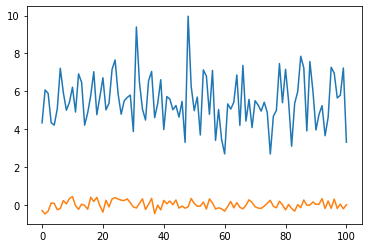

In [103]:
plt.plot(np.arange(max_iter+1), cost_gadget)
plt.plot(np.arange(max_iter+1), cost_computational)
plt.show()